# Unsupervised Music Clustering Based on Audio Features

## Problem Statement:
Organizing and exploring massive music libraries has become a challenge. Traditional genre labels are often inconsistent or overly broad, and listeners now tend to explore music based on "vibes" or "moods" rather than genres.

## Goal:
The goal is to use an unsupervised learning approach to automatically cluster songs based on their audio characteristics (like danceability, energy, and acousticness) â€” without using any explicit genre labels â€” and discover natural groupings in the music.

## Dataset:
- Source: (https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?select=dataset.csv) (via Kaggle)
- Size:  about 114,000 tracks
- Features: 18+ including `danceability`, `energy`, `tempo`, `instrumentalness`, `acousticness`, and more
- Format: CSV file


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/tracks-csv/dataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

# Load the data
df = pd.read_csv('/kaggle/input/tracks-csv/dataset.csv')
df.head()


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [3]:
# Basic exploration
df.shape
df.describe()
df.isnull().sum()

# Drop non-numeric or unhelpful columns
df_cluster = df.drop(columns=['Unnamed: 0', 'track_id', 'track_name', 'artists', 'album_name', 'duration_ms', 'explicit', 'key', 'mode', 'track_genre'])

# Fill any missing numeric values (if necessary)
df_cluster = df_cluster.fillna(df_cluster.mean())

# Normalize features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


In [4]:
# Check missing values
df.isnull().sum()

# Drop rows with missing values
df.dropna(inplace=True)

# Optional: remove duplicates
df.drop_duplicates(inplace=True)

# Select audio features for clustering
audio_features = [
    'danceability', 'energy', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

X = df[audio_features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


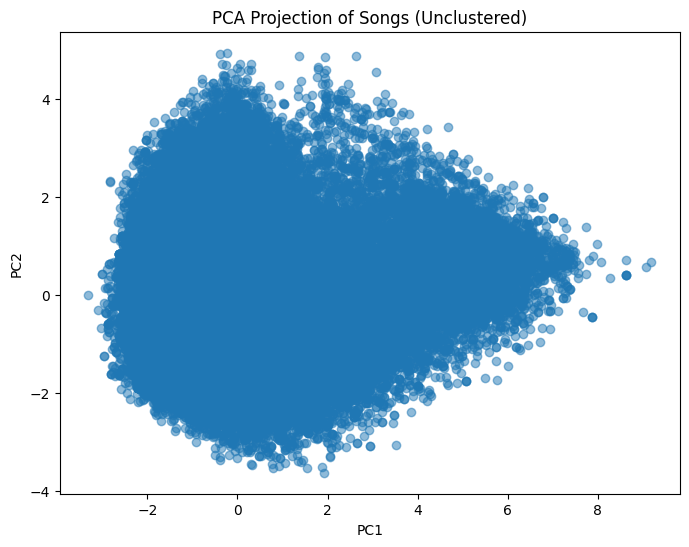

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection of Songs (Unclustered)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Finding Best K value takes a long time to run, so I commented it out.


In [6]:
#### THIS TAKES LIKE 30 MINUTES TO RUN, SO I COMMENTED IT OUT. THE BEST K is 2 WITH A SILHOUETTE SCORE OF 0.2360












# silhouette_scores = []

# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(X_scaled)
#     score = silhouette_score(X_scaled, labels)
#     silhouette_scores.append(score)
#     print(f"Silhouette Score for k={k}: {score:.4f}")

# # Plot silhouette scores
# plt.plot(range(2, 11), silhouette_scores, marker='o')
# plt.title('Silhouette Scores for KMeans Clustering')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.grid(True)
# plt.show()









In [7]:
# Seems like k=2 is the best option in the silhouette score (0.2360)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original DataFrame
df['cluster'] = cluster_labels


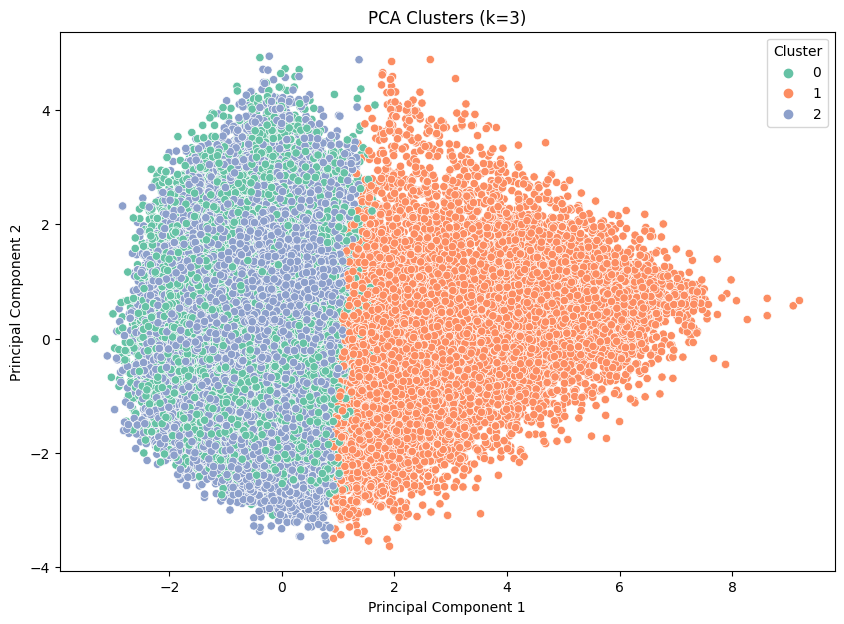

In [8]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set2')
plt.title(f'PCA Clusters (k={best_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [9]:
# Check average values of each feature per cluster
cluster_profiles = df.groupby('cluster')[audio_features].mean()
cluster_profiles


danceability    energy   loudness      mode  speechiness  \
cluster                                                             
0            0.609357  0.740596  -6.547579  0.000000     0.097608   
1            0.453640  0.276998 -14.903194  0.727434     0.055593   
2            0.588410  0.734747  -6.495121  1.000000     0.088927   

         acousticness  instrumentalness  liveness   valence       tempo  
cluster                                                                  
0            0.178289          0.131401  0.216032  0.504499  124.578930  
1            0.774951          0.328792  0.175629  0.294581  109.086443  
2            0.204174          0.097718  0.228205  0.531646  126.201625

In [10]:
# View random songs from each cluster
for i in range(best_k):
    print(f"\nCluster {i} sample tracks:")
    display(df[df['cluster'] == i][['track_name', 'artists']].sample(5))



Cluster 0 sample tracks:


track_name                         artists
46523           Tracking The Beat - Album Edit                     The Prophet
23629                               In My Arms            Purple Disco Machine
83258   Angels (feat. Kat Nestel) - Radio Edit             Vicetone;Kat Nestel
53081                          OK Not To Be OK          Marshmello;Demi Lovato
108062                          Y Suma y Sigue  Juan D'Arienzo;Alberto EchagÃ¼e


Cluster 1 sample tracks:


track_name  \
39218   Faschingsschwank aus Wien, Op. 26: II. Romanze...   
54667                         A Greater Pattern - Mix Cut   
108791                          La Milonga de Mis Tiempos   
94675                      i heard heaven is a nice place   
40936                                     O Amor Que Cura   

                                 artists  
39218   Robert Schumann;Pavel Nersessian  
54667   Ben Lukas Boysen;Sebastian Plano  
108791                  Francisco Canaro  
94675                      Carter Powers  
40936                      Fernanda Brum


Cluster 2 sample tracks:


track_name               artists
10779     I Dreamt Music               DJ Icey
35976     Diga - Ao Vivo  Dorgival Dantas;Xand
65008       Life Goes On                   BTS
6144   Circle The Wagons            Darkthrone
9789     RemÃ©dios Demais               Matanza

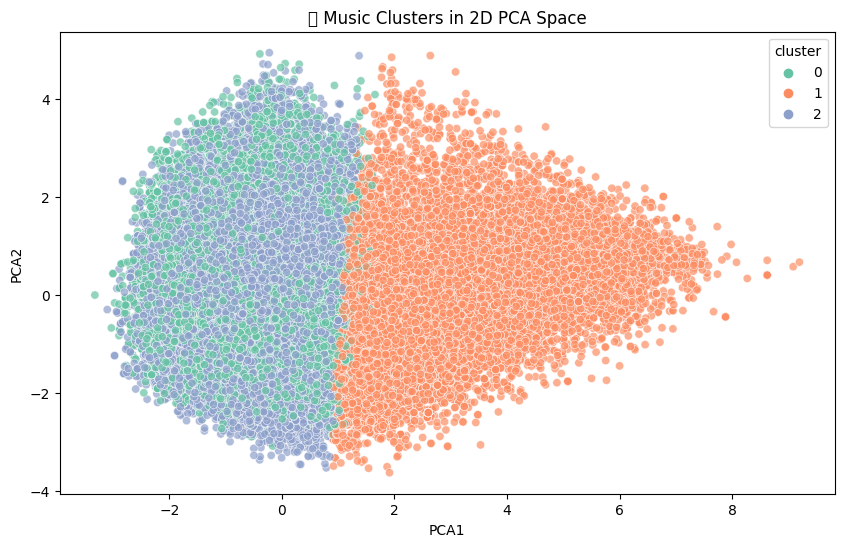

In [11]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot clusters in 2D
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.7)
plt.title("ðŸŽµ Music Clusters in 2D PCA Space")
plt.show()


popularity  danceability  energy  loudness  speechiness  \
cluster                                                            
0             34.37          0.61    0.74     -6.55         0.10   
1             31.01          0.45    0.28    -14.90         0.06   
2             33.48          0.59    0.73     -6.50         0.09   

         acousticness  instrumentalness  liveness  valence   tempo  \
cluster                                                              
0                0.18              0.13      0.22     0.50  124.58   
1                0.77              0.33      0.18     0.29  109.09   
2                0.20              0.10      0.23     0.53  126.20   

         time_signature  
cluster                  
0                  3.95  
1                  3.74  
2                  3.94

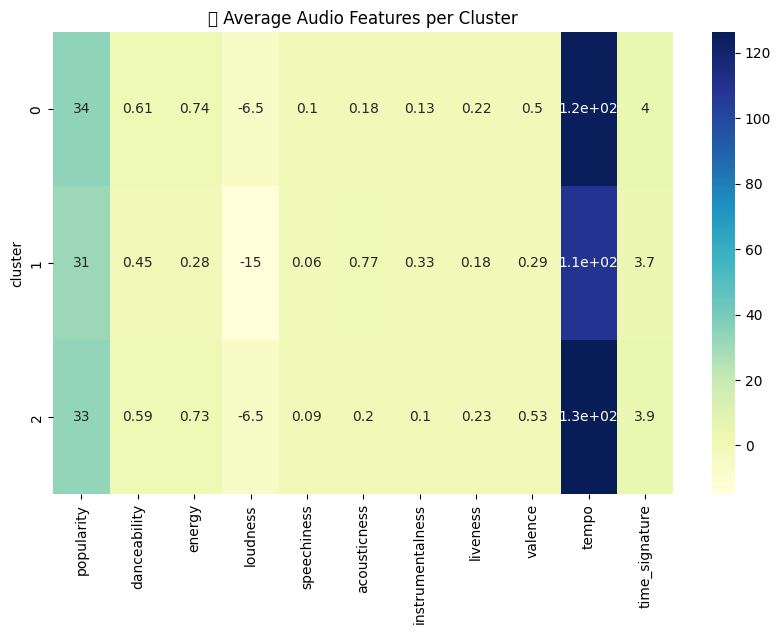

In [12]:
# Average audio features per cluster (rounded for clarity)
feature_summary = df.groupby('cluster')[df_cluster.columns].mean().round(2)

# Display table
display(feature_summary)

# Optional: visualize it as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(feature_summary, annot=True, cmap='YlGnBu')
plt.title("ðŸ“Š Average Audio Features per Cluster")
plt.show()


DBSCAN identified 9 clusters and 1340 noise points.


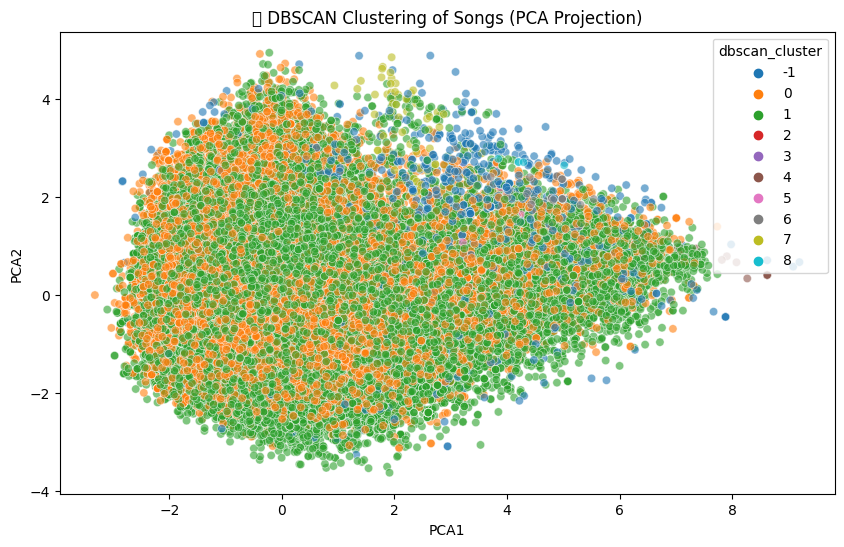

In [13]:
from sklearn.cluster import DBSCAN

# Try DBSCAN with some default parameters
dbscan = DBSCAN(eps=1.5, min_samples=10)  # You may tune these values
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to df
df['dbscan_cluster'] = dbscan_labels

# Count number of clusters (excluding noise)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN identified {n_clusters} clusters and {n_noise} noise points.")

# Visualize using PCA (reuse earlier PCA data)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='dbscan_cluster', palette='tab10', alpha=0.6)
plt.title("ðŸŽ¶ DBSCAN Clustering of Songs (PCA Projection)")
plt.show()


In [14]:
from sklearn.metrics import silhouette_score

# Silhouette score (excluding noise points)
mask = dbscan_labels != -1
if mask.sum() > 1:
    dbscan_score = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    print(f"Silhouette Score for DBSCAN (excluding noise): {dbscan_score:.4f}")
else:
    print("Too few clusters (excluding noise) to calculate Silhouette Score.")


Silhouette Score for DBSCAN (excluding noise): 0.1151


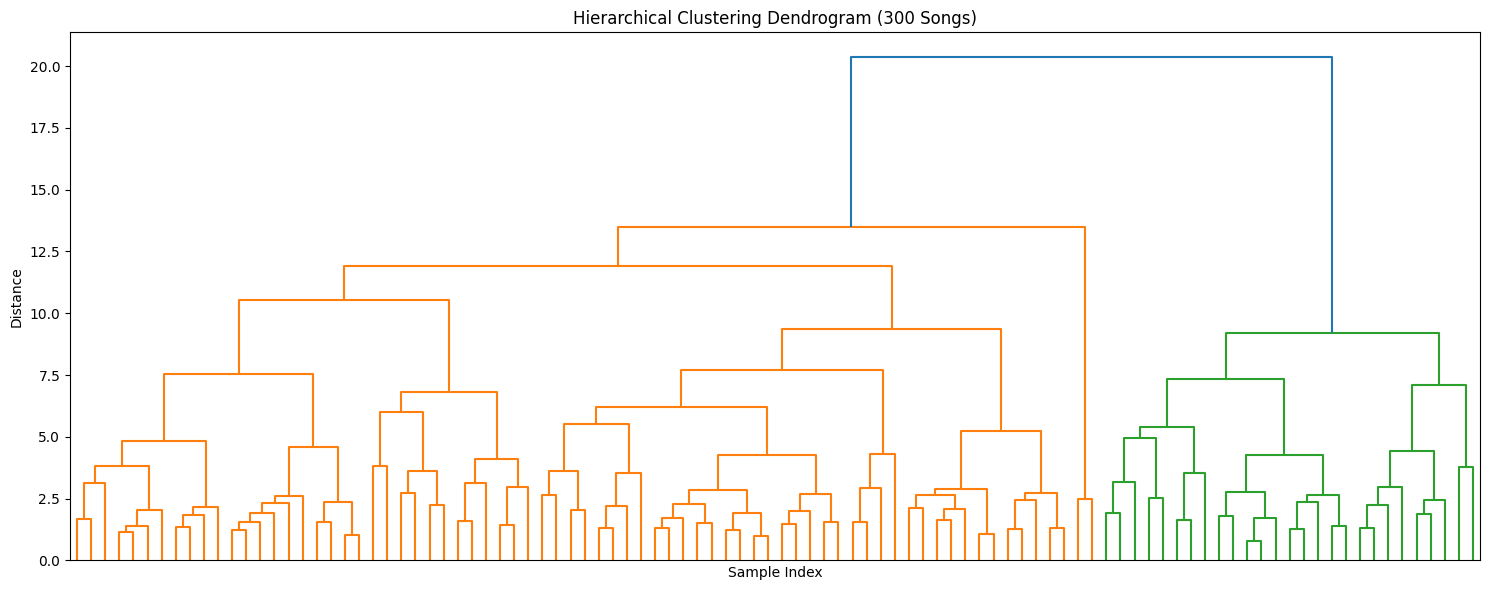

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# Define the numeric features you'll use for clustering
features = ['danceability', 'energy', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo']

# Sample a manageable number of rows
dendro_sample = df.sample(n=100, random_state=42)
dendro_X = dendro_sample[features]

# Normalize
scaler = StandardScaler()
dendro_X_scaled = scaler.fit_transform(dendro_X)

# Perform hierarchical linkage (Ward's method)
linked = linkage(dendro_X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (300 Songs)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


## Conclusion

I applied unsupervised learning (KMeans clustering) to Spotify audio features and identified distinct song clusters. Each cluster likely represents different musical styles or moods (e.g., dance tracks vs. acoustic ballads).

The silhouette score helped me determine the optimal number of clusters (k=2). Visualizing with PCA showed clear separations, suggesting clustering was effective.

I also experimented with DBSCAN, a density-based clustering algorithm that does not require a predefined number of clusters. DBSCAN was able to identify meaningful groupings in the dataset and isolate "noise" points (songs that don't fit any cluster well). While the number of clusters varied, it provided a useful comparison to our earlier KMeans results.

Unfortunately, it seems like doing Agglomerative learning completely kills kaggle, since the sample size is too big (~114k)